In [35]:
from pydantic_settings import BaseSettings
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import List, TypedDict, Dict, Any, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage,  SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import MessagesState
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, Column, Integer, Float, String, MetaData, Table
load_dotenv()

True

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini") 

### Code for uploading the csv file to a database and also connecting to postgres database using sqlalchemy

In [2]:
class Settings(BaseSettings):
    database_hostname: str
    database_port: str
    database_password: str
    database_name: str
    database_username: str

    openai_api_key: str
    langsmith_tracing: bool
    langsmith_endpoint: str
    langsmith_api_key: str
    langsmith_project: str
    tavily_api_key: str

    class Config:
        env_file = ".env"
        extra = "allow"

# Initialize settings
settings = Settings()

In [20]:
def load_csv_from_path(csv_path):
    """Load a CSV file from a given path into a Pandas DataFrame."""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")
    
    return pd.read_csv(csv_path)

In [19]:
def infer_column_types(df):
    """Infer SQL column types from DataFrame"""
    type_map = {}
    
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            type_map[col] = Integer
        elif pd.api.types.is_float_dtype(df[col]):
            type_map[col] = Float
        else:
            type_map[col] = String(255)
    
    return type_map

In [26]:
Base = declarative_base()
metadata = MetaData()

/tmp/ipykernel_29987/3181227891.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [25]:
def create_database_and_table(df, database_name=None, table_name=None):
    """Create a new database and table based on DataFrame schema"""
    # Generate names if not provided
    if database_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        database_name = f"analysis_db_{timestamp}"
    
    if table_name is None:
        table_name = "data_table"
    
    settings.database_name = database_name
    
    admin_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/postgres"
    )
    
    with admin_engine.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        conn.execute(f"DROP DATABASE IF EXISTS {database_name}")
        conn.execute(f"CREATE DATABASE {database_name}")
    
    db_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{database_name}"
    )
    
    column_types = infer_column_types(df)
    
    # Create table
    columns = [Column('id', Integer, primary_key=True)]
    schema_info = {'id': 'Integer (primary key)'}
    
    for col_name, sql_type in column_types.items():
        safe_col_name = col_name.replace(' ', '_').lower()
        columns.append(Column(safe_col_name, sql_type))
        
        if isinstance(sql_type, type):
            type_name = sql_type.__name__
        else:
            type_name = str(sql_type)
        
        schema_info[safe_col_name] = type_name
    
    table = Table(table_name, metadata, *columns)
    metadata.create_all(db_engine)
    
    # Prepare data with safe column names
    df_to_insert = df.copy()
    df_to_insert.columns = [col.replace(' ', '_').lower() for col in df.columns]
    
    # Insert data
    with db_engine.connect() as conn:
        # Insert in batches to handle large datasets
        batch_size = 1000
        for i in range(0, len(df_to_insert), batch_size):
            batch = df_to_insert.iloc[i:i+batch_size]
            batch.to_sql(table_name, conn, if_exists='append', index=False)
    
    return {
        'database_name': database_name,
        'table_name': table_name,
        'schema': schema_info,
        'engine': db_engine
    }

In [24]:
def get_db_connection(database_name=None):
    """Get a database connection to the specified database"""
    db_name = database_name or settings.database_name
    
    if not db_name:
        raise ValueError("No database name specified")
    
    engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{db_name}"
    )
    
    SessionLocal = sessionmaker(autoflush=False, bind=engine, autocommit=False)
    db = SessionLocal()
    
    return db, engine

### Generate analyst with human in the loop

In [ ]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    role: str = Field(description="Role of the analyst in the context of data analysis.")
    data_analysis_focus: str = Field(description="Primary focus area in data analysis (e.g., Machine Learning, Statistical Analysis, Data Engineering).")
    description: str = Field(description="Description of the analyst's expertise, concerns, and analysis approach.")

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Focus: {self.data_analysis_focus}\n"
            f"Description: {self.description}\n"
        )

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="List of analysts contributing to the data analysis.")
    analysis_summary: str = Field(description="Summary of findings from all analysts.")

class GenerateAnalystsState(TypedDict):
    csv_path: str  # Path to the uploaded CSV file
    analysis_goal: str  # Goal of the analysis
    max_analysts: int  # Maximum number of analysts to create
    human_analyst_feedback: Optional[str]  # Optional human feedback
    database_name: Optional[str]  # Database name (generated or provided)
    table_name: Optional[str]  # Table name (generated or provided)
    analysts: Optional[List[Analyst]]  # Generated analysts
    data_df: Dict[str, Any]  # To store dataframes at different stages
    ml_models: Dict[str, Any]  # To store trained models
    visualizations: Dict[str, str]  # To store visualization references
    database_schema: Optional[Dict[str, str]]  # Schema of the created database
    analysis_summary: Optional[str]  # Final analysis summary

In [10]:
# Enhanced instructions for analysts
analyst_instructions = """You are tasked with creating a set of AI analyst personas that will perform data analysis tasks. Follow these instructions carefully:

1. First, review the research topic and dataset:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_analyst_feedback}
    
3. Determine the most interesting themes based on the dataset and analysis goals.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme, ensuring diversity in roles:
   - Include at least one database engineer for database creation and management
   - Include at least one data engineer for data preparation and ETL processes
   - Include at least one data visualization expert
   - Include at least one machine learning specialist
   - Include at least one statistical analyst

6. For each analyst, provide a detailed description of their expertise and how they would approach the analysis.
"""

In [27]:
def process_csv_and_create_db(state: GenerateAnalystsState):
    """Load CSV and create database"""
    csv_path = state['csv_path']
    
    try:
        # Read CSV into pandas DataFrame
        df = pd.read_csv(csv_path)
        
        # Create initial data structure
        data_df = {"raw": df}
        
        # Create database and table
        db_info = create_database_and_table(
            df, 
            database_name=state.get('database_name'),
            table_name=state.get('table_name')
        )
        
        return {
            "data_df": data_df,
            "database_name": db_info['database_name'],
            "table_name": db_info['table_name'],
            "database_schema": db_info['schema']
        }
    except Exception as e:
        return {
            "data_df": {"error": str(e)},
            "error_message": f"Failed to process CSV and create database: {str(e)}"
        }

In [28]:
def create_analysts(state: GenerateAnalystsState):
    """Create analysts based on the dataset and analysis goals"""
    
    # Create description of the data and task for the LLM
    db_info = f"Database: {state['database_name']}, Table: {state['table_name']}"
    schema_info = "Schema: " + ", ".join([f"{k}: {v}" for k, v in state['database_schema'].items()])
    data_sample = "Sample data: " + str(state['data_df']['raw'].head(3).to_dict())
    
    topic = f"{db_info}\n{schema_info}\n{data_sample}\n\nAnalysis Goal: {state['analysis_goal']}"
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate analysts
    analysts = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts that will create and interact with the database, analyze the data, clean it, visualize it, perform data engineering tasks, and build machine learning models.")
    ])
    
    # Write the list of analysts to state
    return {"analysts": analysts.analysts}

In [29]:
def perform_database_interactions(state: GenerateAnalystsState):
    """Have analysts interact with the database to perform various queries and transformations"""
    database_name = state['database_name']
    table_name = state['table_name']
    analysts = state['analysts']
    
    # Get database connection
    db, engine = get_db_connection(database_name)
    
    try:
        # Track all database interactions
        all_interactions = []
        
        # Find database-focused analysts
        db_analysts = [a for a in analysts if "Database" in a.data_analysis_focus or "Data Engineer" in a.role]
        
        for analyst in db_analysts:
            interactions = []
            
            # Basic stats query
            stats_query = f"""
            SELECT 
                COUNT(*) as row_count,
                (SELECT COUNT(*) FROM information_schema.columns WHERE table_name = '{table_name}') as column_count
            FROM {table_name}
            """
            stats_result = pd.read_sql(stats_query, engine)
            interactions.append({
                "query": stats_query,
                "description": "Basic table statistics",
                "result_summary": f"Table has {stats_result['row_count'][0]} rows and {stats_result['column_count'][0]} columns"
            })
            
            # Find numeric columns for aggregation
            column_query = f"""
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = '{table_name}'
            AND data_type IN ('integer', 'numeric', 'real', 'double precision')
            """
            numeric_cols = pd.read_sql(column_query, engine)
            
            # If we have numeric columns, perform aggregate queries
            if not numeric_cols.empty:
                col_names = numeric_cols['column_name'].tolist()
                agg_cols = ", ".join([f"AVG({col}) as avg_{col}, MIN({col}) as min_{col}, MAX({col}) as max_{col}" 
                                     for col in col_names])
                
                agg_query = f"""
                SELECT {agg_cols}
                FROM {table_name}
                """
                
                agg_results = pd.read_sql(agg_query, engine)
                interactions.append({
                    "query": agg_query,
                    "description": "Aggregate statistics on numeric columns",
                    "result_summary": "Calculated AVG, MIN, MAX for all numeric columns"
                })
                
                # Create an aggregated view for ML purposes
                view_name = f"agg_{table_name}_view"
                create_view_query = f"""
                CREATE OR REPLACE VIEW {view_name} AS
                SELECT {', '.join(col_names)}
                FROM {table_name}
                """
                
                with engine.connect() as conn:
                    conn.execute(create_view_query)
                
                interactions.append({
                    "query": create_view_query,
                    "description": "Created aggregated view for ML analysis",
                    "result_summary": f"View {view_name} created with columns: {', '.join(col_names)}"
                })
            
            # Update analyst with interactions
            analyst.database_interactions = interactions
            all_interactions.extend(interactions)
        
        # Store the aggregated results in state for future use
        return {
            "database_interactions": all_interactions
        }
        
    except Exception as e:
        return {
            "database_interactions": [],
            "error_message": f"Failed to perform database interactions: {str(e)}"
        }
    finally:
        db.close()

In [33]:
def data_cleaning_and_enrichment(state: GenerateAnalystsState):
    """Clean and enrich the data, updating the database with cleaned data"""
    if "error" in state["data_df"]:
        return {"data_df": state["data_df"]}  # Return error if data fetch failed
        
    raw_df = state["data_df"]["raw"]
    
    # Basic cleaning operations
    clean_df = raw_df.copy()
    
    # Handle missing values - impute with means for numeric, most frequent for categorical
    for col in clean_df.columns:
        if pd.api.types.is_numeric_dtype(clean_df[col]):
            clean_df[col] = clean_df[col].fillna(clean_df[col].mean())
        else:
            clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0] if not clean_df[col].mode().empty else "Unknown")
    
    # Remove duplicates
    clean_df = clean_df.drop_duplicates()
    
    # Feature engineering - add some derived columns based on numeric data
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_cols) >= 2:
        # Create a sum column of first two numeric columns as an example
        col1, col2 = numeric_cols[0], numeric_cols[1]
        clean_df[f'sum_{col1}_{col2}'] = clean_df[col1] + clean_df[col2]
        
        # Create a ratio column if values allow
        if (clean_df[col2] != 0).all():
            clean_df[f'ratio_{col1}_{col2}'] = clean_df[col1] / clean_df[col2]
    
    # Store the cleaned data back to the database
    db, engine = get_db_connection(state['database_name'])
    try:
        # Create a new table for the cleaned data
        cleaned_table_name = f"{state['table_name']}_cleaned"
        clean_df.to_sql(cleaned_table_name, engine, if_exists='replace', index=False)
        
        # Update state
        state["data_df"]["cleaned"] = clean_df
        state["cleaned_table_name"] = cleaned_table_name
        
        return {
            "data_df": state["data_df"],
            "cleaned_table_name": cleaned_table_name
        }
    except Exception as e:
        return {
            "data_df": state["data_df"],
            "error_message": f"Failed to save cleaned data to database: {str(e)}"
        }
    finally:
        db.close()

In [32]:
def data_visualization(state: GenerateAnalystsState):
    """Create visualizations of the data"""
    clean_df = state["data_df"]["cleaned"]
    visualizations = {}
    
    # Create visualization directory if it doesn't exist
    viz_dir = os.path.join(settings.upload_folder, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    # Generate a timestamp-based prefix for visualization files
    viz_prefix = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Correlation heatmap for numeric columns
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = clean_df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        corr_file = os.path.join(viz_dir, f'{viz_prefix}_correlation_heatmap.png')
        plt.savefig(corr_file)
        plt.close()
        visualizations['correlation'] = corr_file
    
    # Distribution plots for key features
    for i, col in enumerate(numeric_cols[:3]):  # Limit to first 3 numeric columns
        plt.figure(figsize=(8, 6))
        sns.histplot(clean_df[col], kde=True)
        plt.title(f'Distribution of {col}')
        dist_file = os.path.join(viz_dir, f'{viz_prefix}_dist_{col}.png')
        plt.savefig(dist_file)
        plt.close()
        visualizations[f'dist_{col}'] = dist_file
    
    # Pair plot for numeric features (limited to 4 to avoid too large plots)
    if len(numeric_cols) > 1:
        plot_cols = numeric_cols[:min(4, len(numeric_cols))]
        plt.figure(figsize=(12, 10))
        sns_pairplot = sns.pairplot(clean_df[plot_cols])
        pair_file = os.path.join(viz_dir, f'{viz_prefix}_pair_plot.png')
        sns_pairplot.savefig(pair_file)
        plt.close()
        visualizations['pair_plot'] = pair_file
    
    # Box plots for each numeric column
    plt.figure(figsize=(12, 6))
    box_data = clean_df[numeric_cols[:min(6, len(numeric_cols))]]
    sns.boxplot(data=box_data)
    plt.title('Box Plots of Numeric Features')
    plt.xticks(rotation=45)
    box_file = os.path.join(viz_dir, f'{viz_prefix}_box_plots.png')
    plt.savefig(box_file)
    plt.close()
    visualizations['box_plots'] = box_file
    
    return {"visualizations": visualizations}

In [34]:
def build_ml_models(state: GenerateAnalystsState):
    """Build machine learning models based on the cleaned data"""
    clean_df = state["data_df"]["cleaned"]
    ml_models = {}
    
    # Identify numeric features
    numeric_features = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_features) > 1:
        # For simplicity, use the last numeric column as target and others as features
        X_cols = numeric_features[:-1]
        y_col = numeric_features[-1]
        
        X = clean_df[X_cols]
        y = clean_df[y_col]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Basic linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Evaluate model
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        
        ml_models['linear_regression'] = {
            'model': model,
            'train_score': train_score,
            'test_score': test_score,
            'features': list(X.columns),
            'target': y_col,
            'coefficients': {feature: coef for feature, coef in zip(X.columns, model.coef_)}
        }
        
        # Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        
        rf_train_score = rf_model.score(X_train_scaled, y_train)
        rf_test_score = rf_model.score(X_test_scaled, y_test)
        
        ml_models['random_forest'] = {
            'model': rf_model,
            'train_score': rf_train_score,
            'test_score': rf_test_score,
            'features': list(X.columns),
            'target': y_col,
            'feature_importance': {feature: importance for feature, importance in 
                                 zip(X.columns, rf_model.feature_importances_)}
        }
        
        # Save model results to database
        db, engine = get_db_connection(state['database_name'])
        try:
            # Create a table for model results
            model_results = pd.DataFrame({
                'model_name': ['linear_regression', 'random_forest'],
                'train_score': [train_score, rf_train_score],
                'test_score': [test_score, rf_test_score],
                'target_variable': [y_col, y_col],
                'timestamp': [datetime.now(), datetime.now()]
            })
            
            model_results.to_sql('model_results', engine, if_exists='replace', index=False)
            
        except Exception as e:
            ml_models['error'] = str(e)
        finally:
            db.close()
    
    return {"ml_models": ml_models}

In [36]:
def generate_analysis_report(state: GenerateAnalystsState):
    """Generate a comprehensive analysis report based on all the previous steps"""
    
    # Extract relevant information from state
    analysts = state['analysts']
    data_df = state['data_df']
    visualizations = state.get('visualizations', {})
    ml_models = state.get('ml_models', {})
    database_name = state['database_name']
    table_name = state['table_name']
    cleaned_table_name = state.get('cleaned_table_name', 'None')
    database_interactions = state.get('database_interactions', [])
    
    # Generate summaries for each analyst based on their focus area
    for analyst in analysts:
        if "Database" in analyst.data_analysis_focus:
            # Database summary
            analyst.analysis_results['database_summary'] = {
                'database_created': database_name,
                'tables_created': [table_name, cleaned_table_name],
                'interactions_count': len(database_interactions)
            }
        
        elif "Data Engineering" in analyst.data_analysis_focus:
            # Data engineering summary
            if 'cleaned' in data_df:
                rows_before = len(data_df['raw'])
                rows_after = len(data_df['cleaned'])
                analyst.analysis_results['data_cleaning'] = {
                    'rows_before': rows_before,
                    'rows_after': rows_after,
                    'cleaning_efficiency': f"{(rows_after/rows_before*100):.1f}%",
                    'cleaned_table': cleaned_table_name
                }
        
        elif "Visualization" in analyst.data_analysis_focus:
            # Visualization summary
            analyst.analysis_results['visualizations'] = list(visualizations.keys())
            
        elif "Machine Learning" in analyst.data_analysis_focus:
            # ML model summary
            if ml_models and 'error' not in ml_models:
                for model_name, model_info in ml_models.items():
                    if model_name != 'error':
                        analyst.analysis_results[model_name] = {
                            'train_score': model_info['train_score'],
                            'test_score': model_info['test_score'],
                            'target': model_info['target']
                        }
    
    # Create a combined analysis summary
    analysis_summary = f"""
    ## Data Analysis Report for {state['analysis_goal']}
    
    ### Database Information
    - Database name: {database_name}
    - Original table: {table_name}
    - Cleaned data table: {cleaned_table_name}
    
    ### Data Overview
    - Raw data rows: {len(data_df['raw']) if 'raw' in data_df else 'N/A'}
    - Cleaned data rows: {len(data_df['cleaned']) if 'cleaned' in data_df else 'N/A'}
    - Features: {', '.join(data_df['raw'].columns) if 'raw' in data_df else 'N/A'}
    
    ### Database Interactions
    - Total interactions: {len(database_interactions)}
    """
    
    # Add visualizations info
    if visualizations:
        analysis_summary += f"""
    ### Key Visualizations
    - Created {len(visualizations)} visualizations:
      - {', '.join(visualizations.keys())}
    """
    
    # Add ML model info
    if ml_models and 'error' not in ml_models:
        model_summaries = []
        for model_name, model_info in ml_models.items():
            if model_name != 'error':
                model_summaries.append(
                    f"- {model_name.replace('_', ' ').title()}: "
                    f"Test score: {model_info['test_score']:.4f}, "
                    f"Target: {model_info['target']}"
                )
        
        analysis_summary += f"""
    ### Machine Learning Models
    {chr(10).join(model_summaries)}
    """
    
    # Add analyst contributions
    analysis_summary += f"""
    ### Analyst Contributions
    {''.join([f"- {a.name} ({a.data_analysis_focus}): {list(a.analysis_results.keys()) if a.analysis_results else 'No results'}\n" for a in analysts])}
    """
    
    # Update state with the report
    return {"analysis_summary": analysis_summary}


In [45]:
def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""
    # Check if human feedback exists
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Build the workflow
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("human_feedback", human_feedback)  # Moved human feedback before database interactions
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    builder.add_edge("create_analysts", "human_feedback")  # Human feedback happens here
    builder.add_edge("human_feedback", "perform_database_interactions")  
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Conditional loop for further human feedback after report generation
    builder.add_conditional_edges("generate_analysis_report", should_continue, ["human_feedback", END])
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
    
    return graph

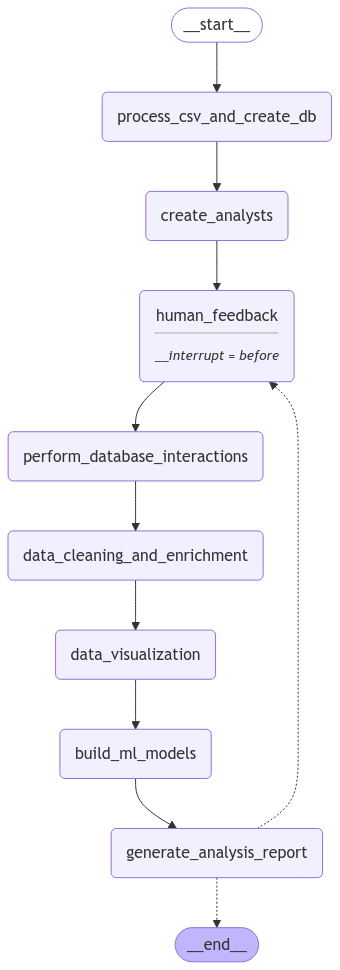

In [46]:
build_analysis_workflow()